# Radar Water Level Monitoring

Here you can find some examples of data processing and plotting.

[data](https://o365coloradoedu-my.sharepoint.com/:f:/r/personal/chhe5305_colorado_edu/Documents/Radar%20Water%20Monitoring/RWM?csf=1&web=1&e=bF4kS6)

In [1]:
import datetime
import os
import pickle

import numpy as np
from tqdm import tqdm

from src import data_utils as utils, plots as plot

%matplotlib inline


data_file = os.path.expanduser('~/data/deployment_nov2023/processed_data.pkl')

## Load Data

In [2]:
with open(data_file, 'rb') as f:
    data = pickle.load(f)

dates, gt, awr1843, iwr1443 = data['dates'], data['ground_truth'], data['AWR1843'], data['IWR1443']
gt_dates, gt_depths = gt

In [3]:
len(dates), len(gt_dates), len(gt_depths)

(114, 746, 746)

In [4]:
awr1843.keys(), iwr1443.keys()

(dict_keys(['x', 'y', 'z', 'intensity']),
 dict_keys(['x', 'y', 'z', 'intensity']))

## Process Data

In [5]:
gt_dates_filtered, gt_depths_filtered = utils.filter_gt(gt_dates, gt_depths, min_depth_threshold=0.1)
print(len(gt_dates_filtered), len(gt_depths_filtered))

475 475


In [6]:
gt_depths_matched = utils.match_gt_to_timestamps(dates, gt_dates_filtered, gt_depths_filtered)
print(len(gt_depths_matched))

114


In [7]:
y_threshold=0.1
y_limit=10
x_limit=1
intensity_threshold_percent=50
window_size=20

In [8]:
awr1843_filtered = utils.filter_points(awr1843, y_threshold=y_threshold, y_limit=y_limit, x_limit=x_limit, intensity_threshold_percent=intensity_threshold_percent)

Filtering points: 100%|██████████| 114/114 [00:01<00:00, 101.39it/s]


In [9]:
awr1843_stats = utils.compute_statistics(awr1843_filtered, window_size=window_size)

100%|██████████| 114/114 [00:03<00:00, 35.24it/s]


In [10]:
iwr1443_filtered = utils.filter_points(iwr1443, y_threshold=y_threshold, y_limit=y_limit, x_limit=x_limit, intensity_threshold_percent=intensity_threshold_percent)

Filtering points: 100%|██████████| 114/114 [00:00<00:00, 686.99it/s]


In [11]:
iwr1443_stats = utils.compute_statistics(iwr1443_filtered, window_size=window_size)

100%|██████████| 114/114 [00:00<00:00, 290.50it/s]


## Plot Data

### AWR 1843

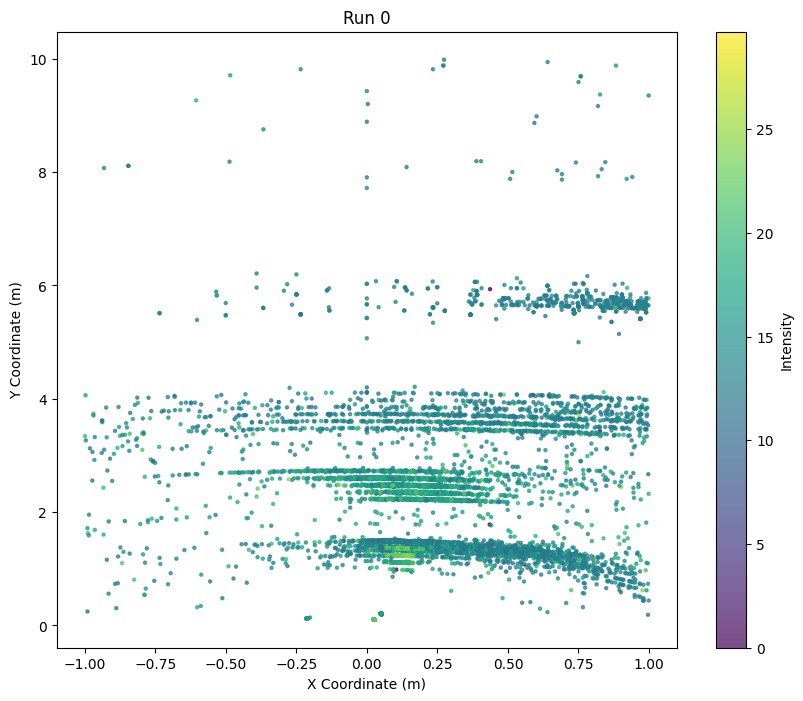

In [12]:
plot.points(awr1843_filtered, run_index=0)

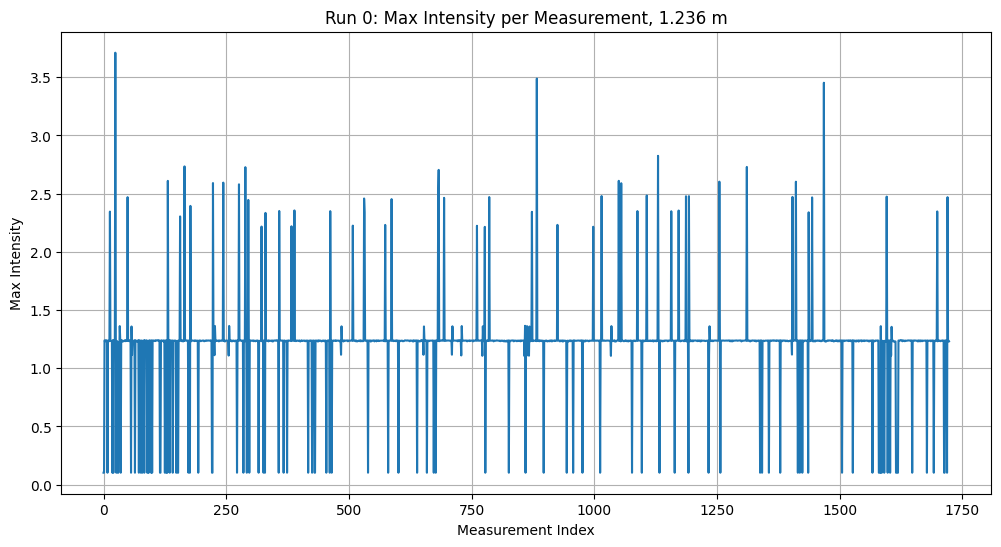

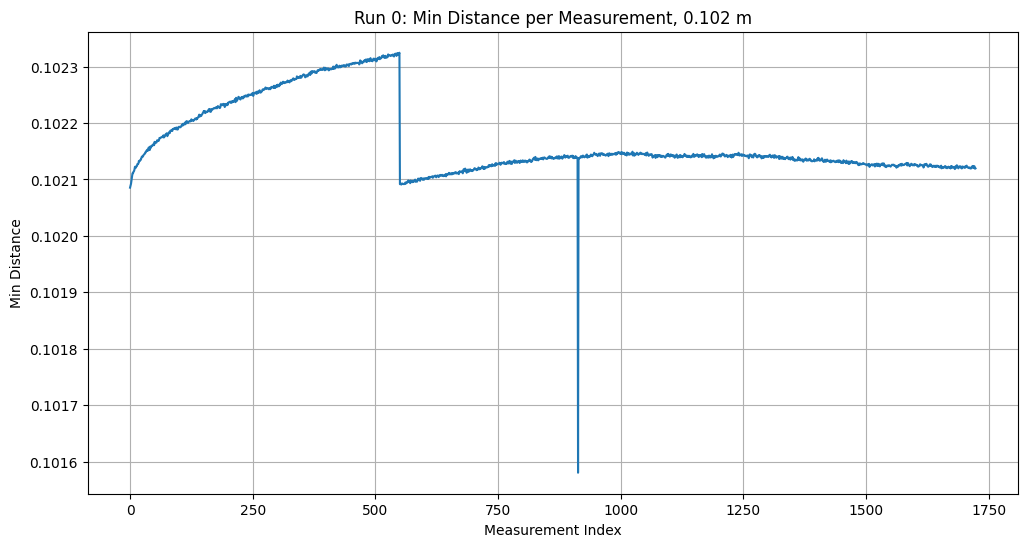

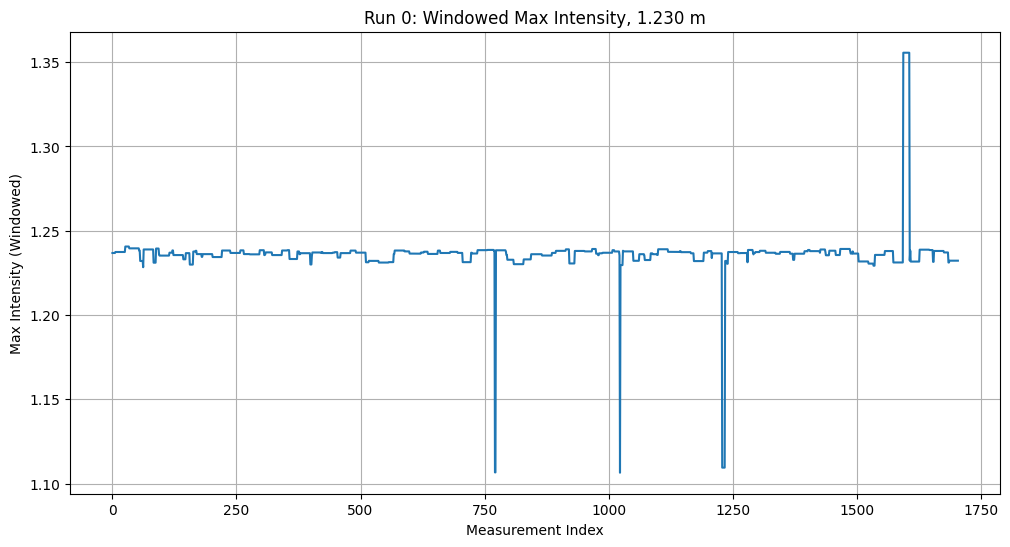

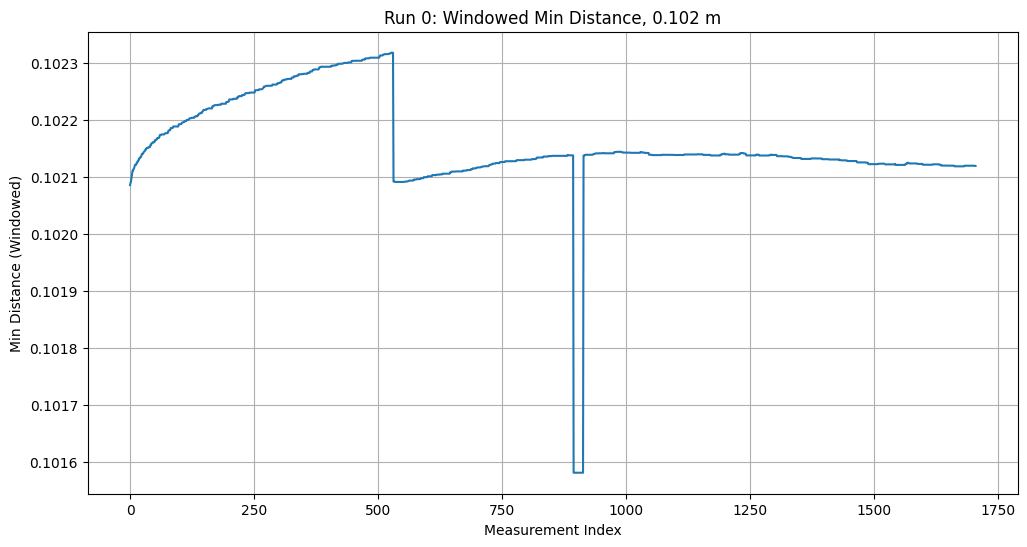

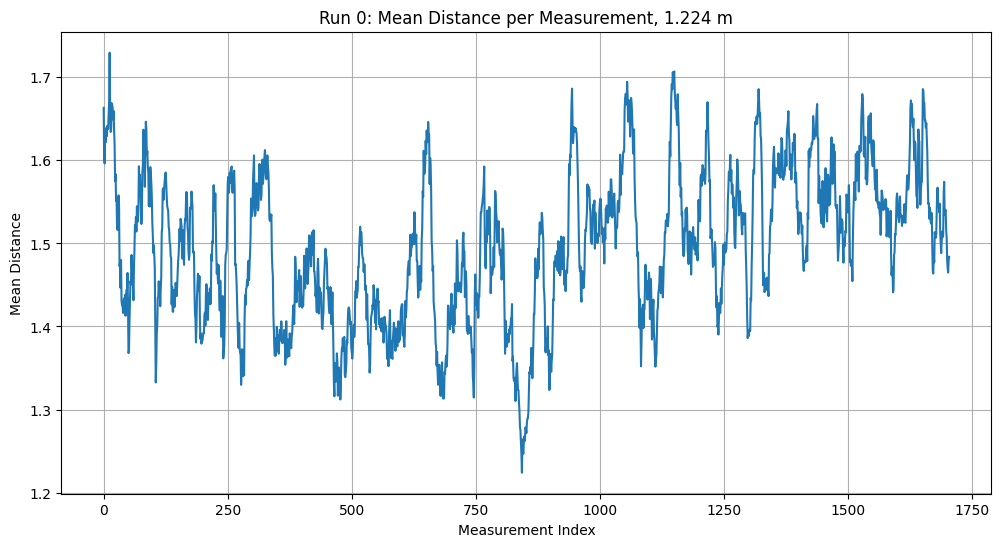

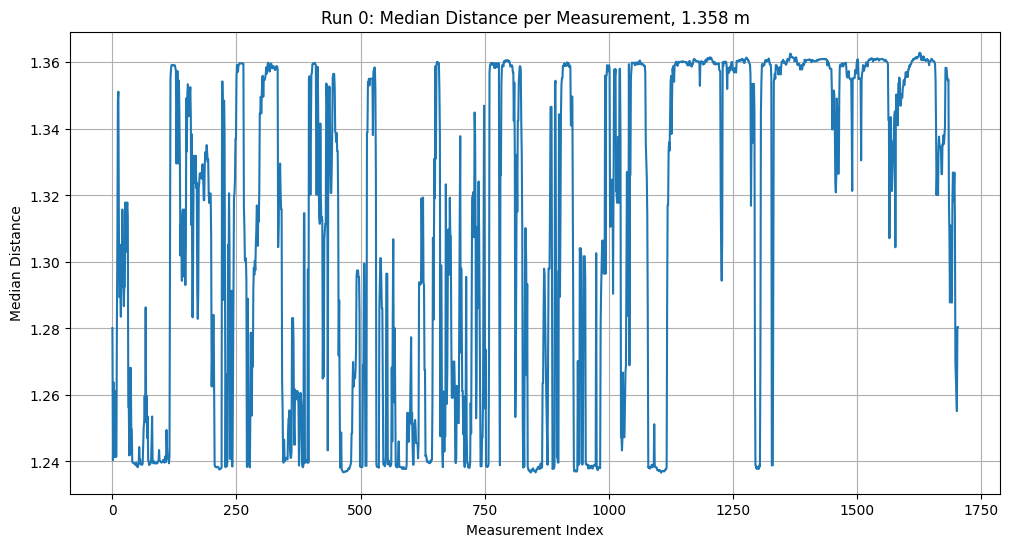

In [13]:
plot.stats(awr1843_stats, run_index=0)

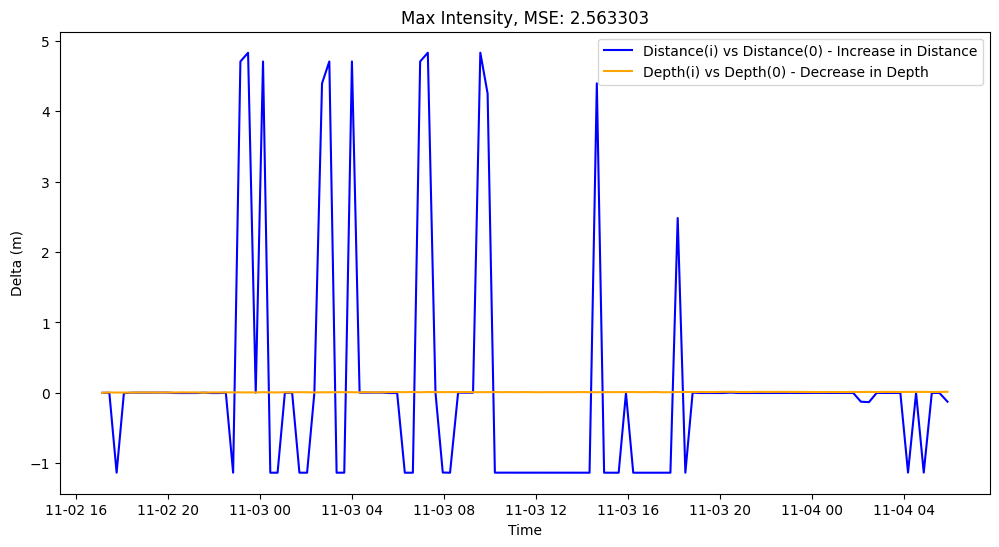

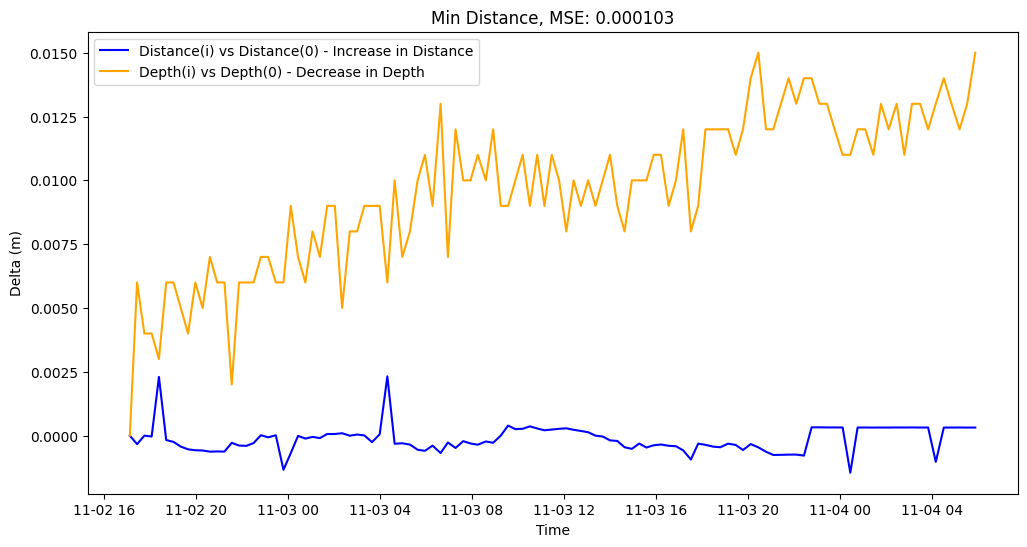

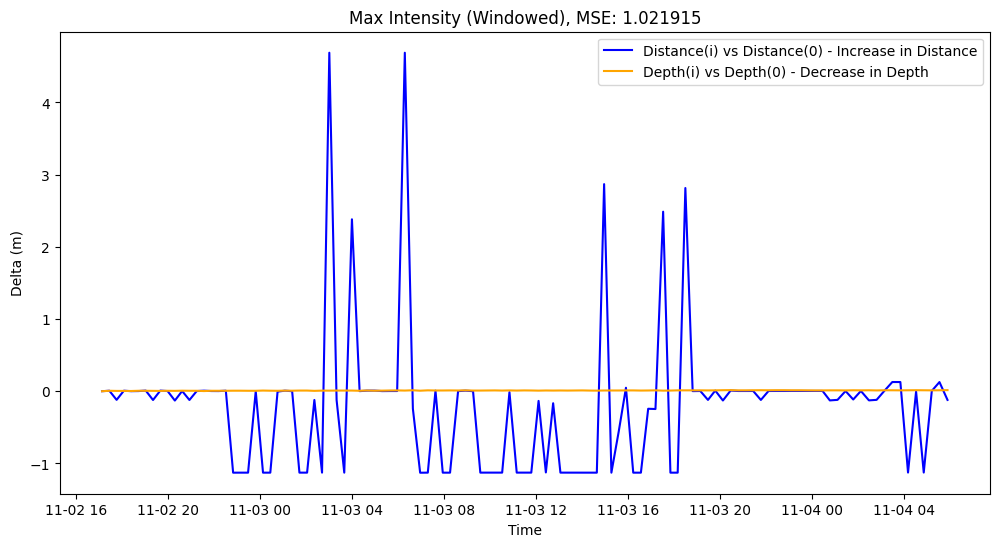

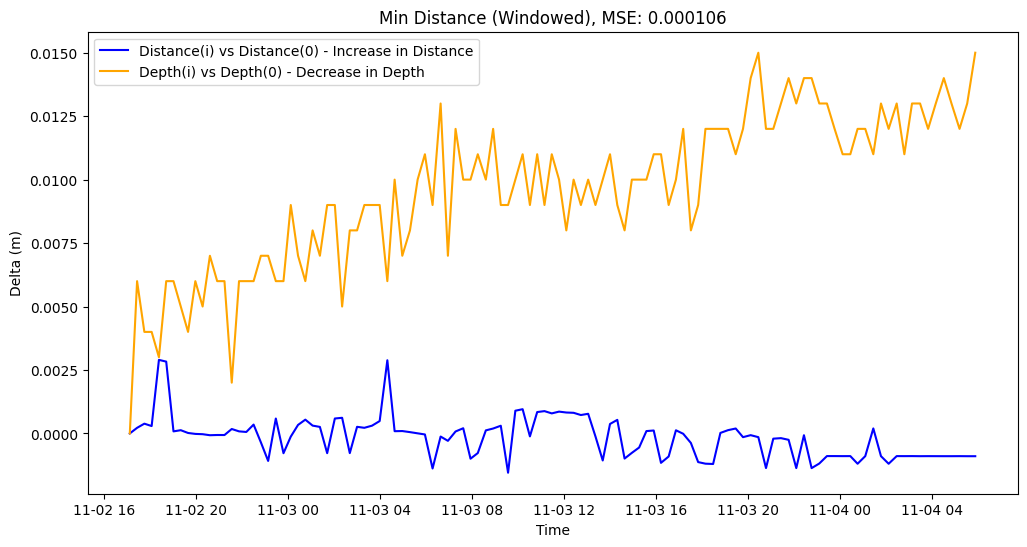

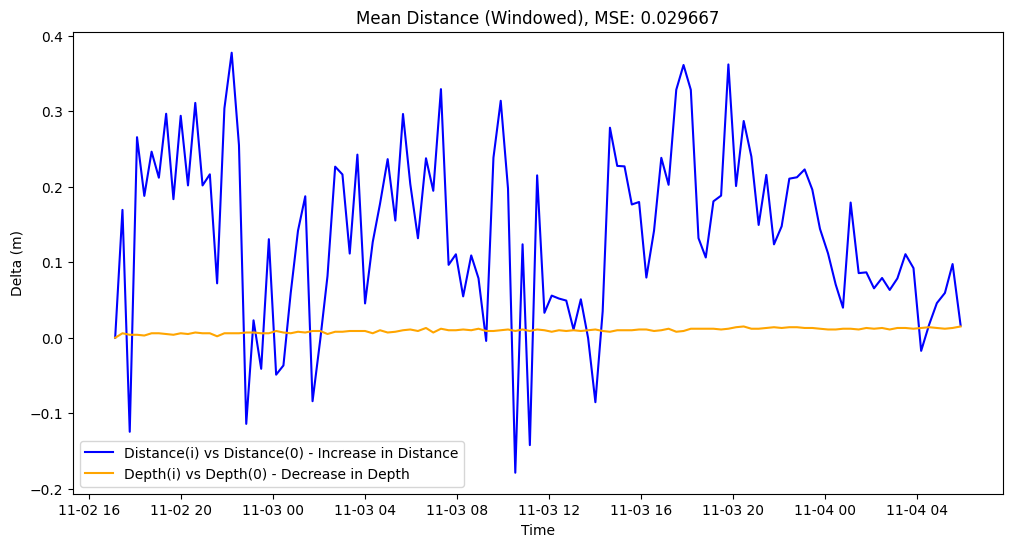

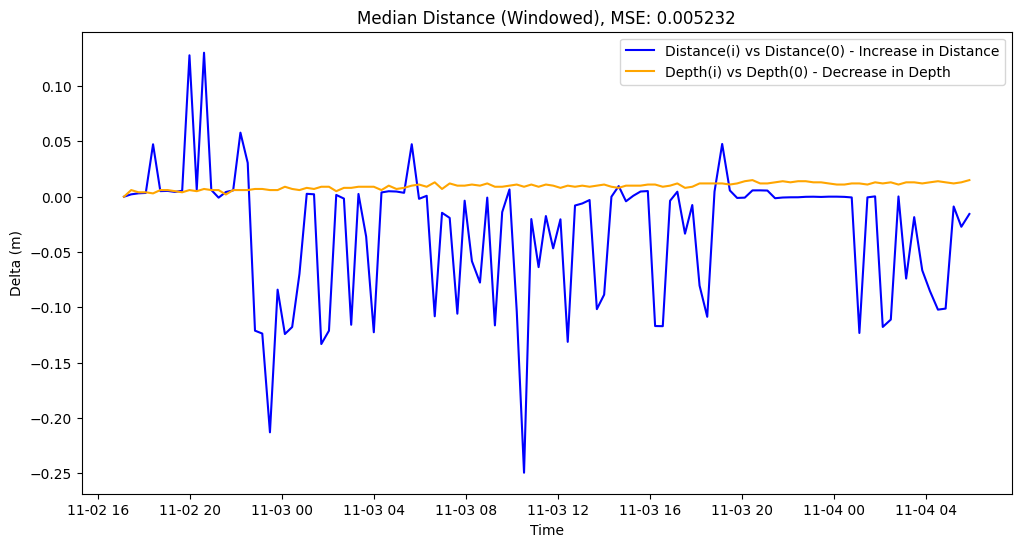

In [14]:
plot.deltas(dates, awr1843_stats, gt_depths_matched)

### IWR 1443

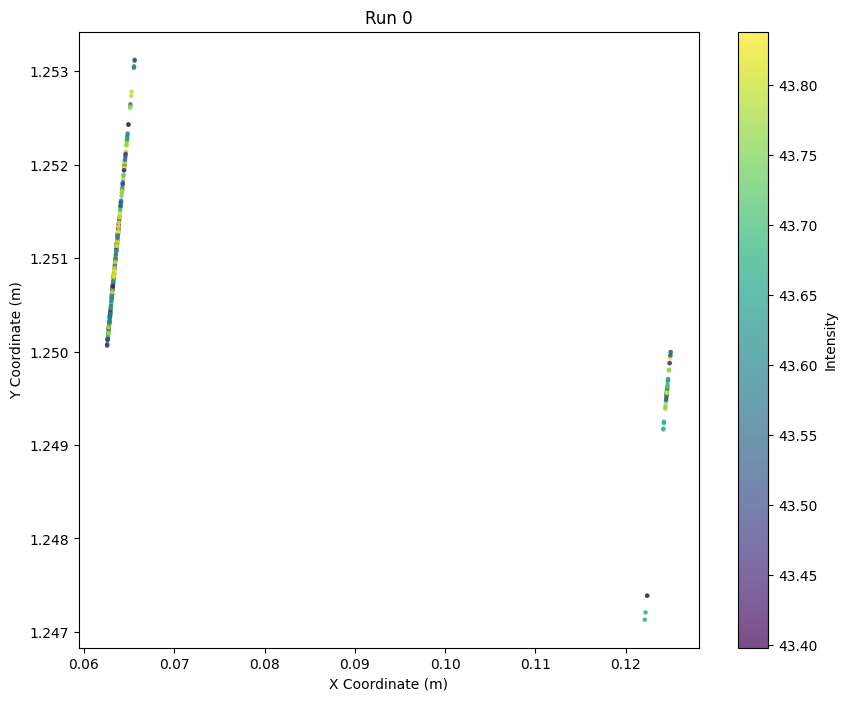

In [15]:
plot.points(iwr1443_filtered, run_index=0)

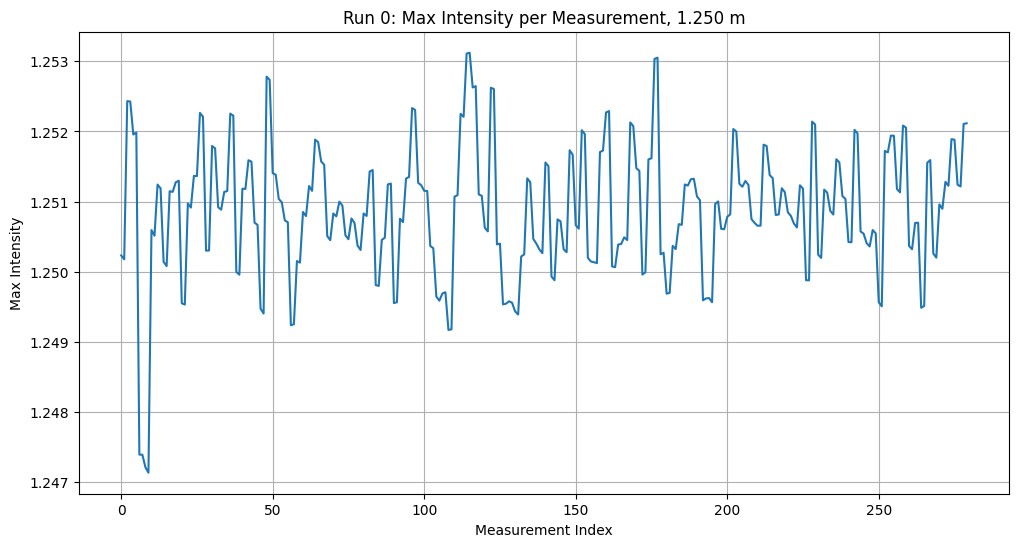

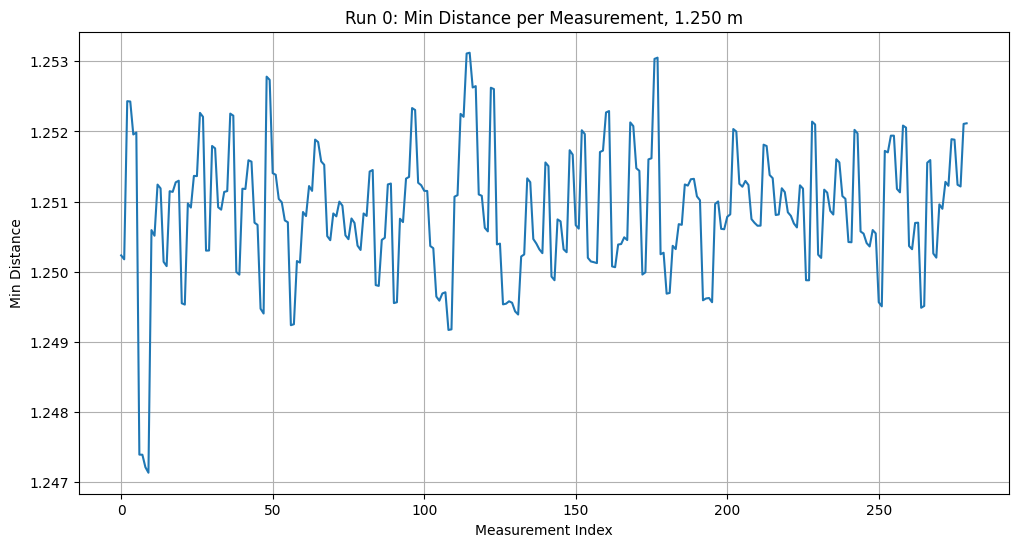

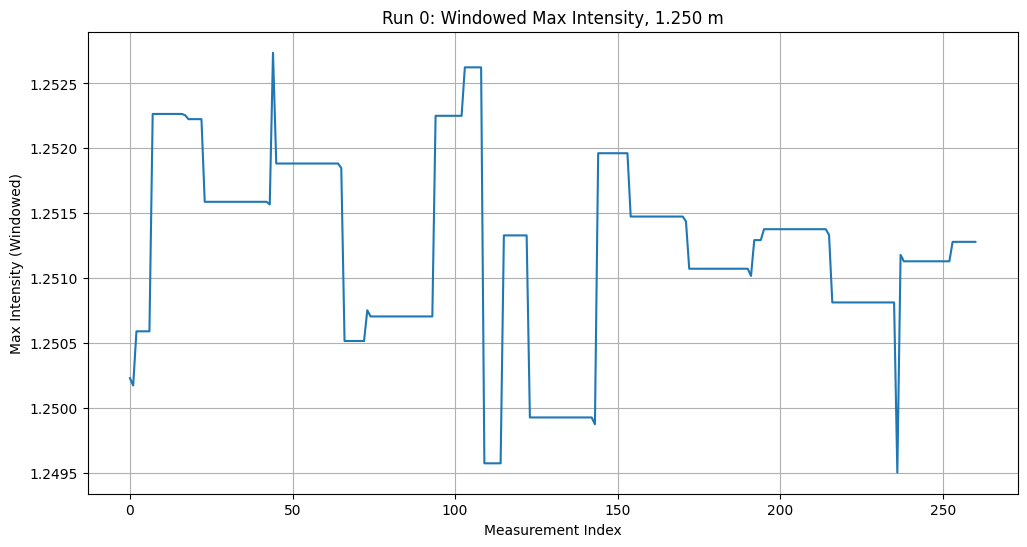

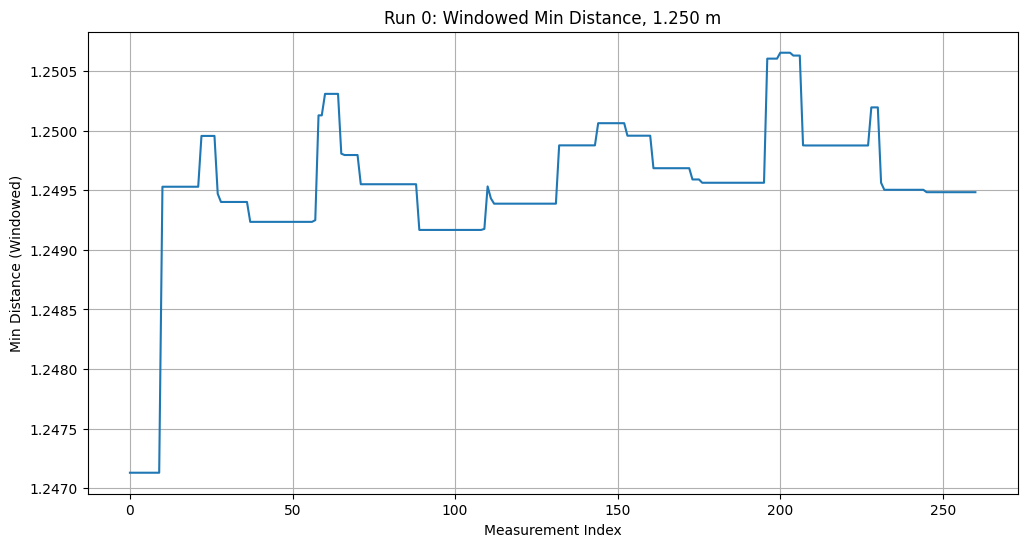

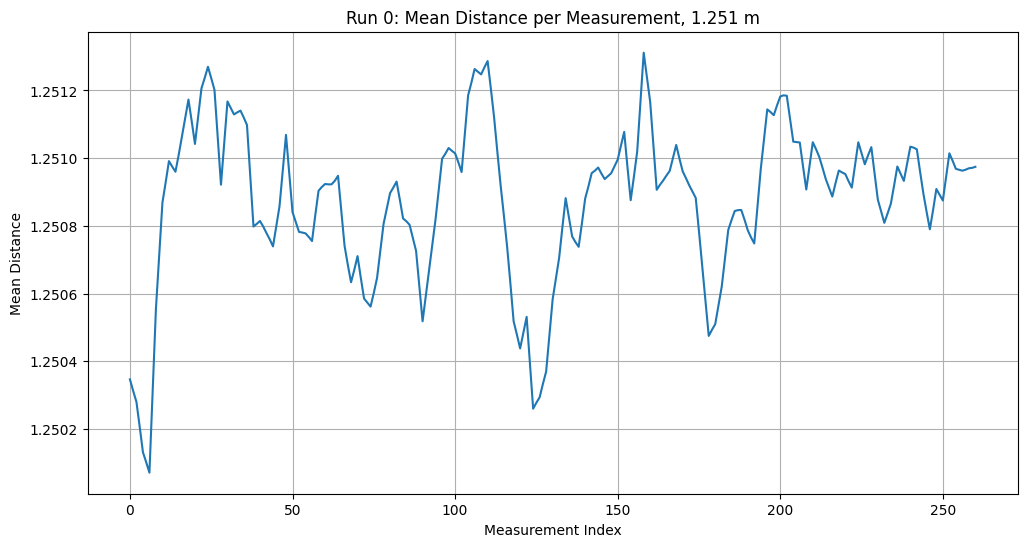

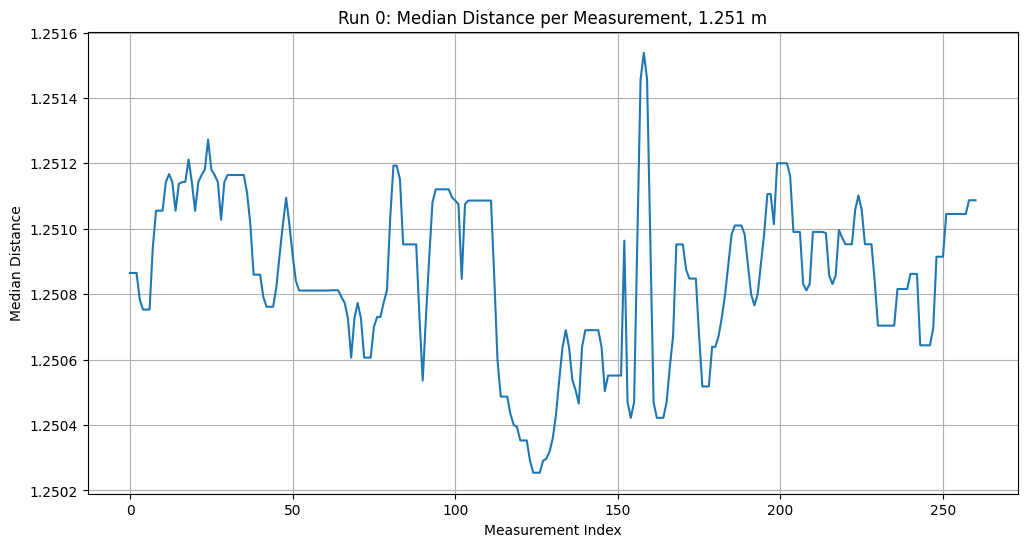

In [16]:
plot.stats(iwr1443_stats, run_index=0)

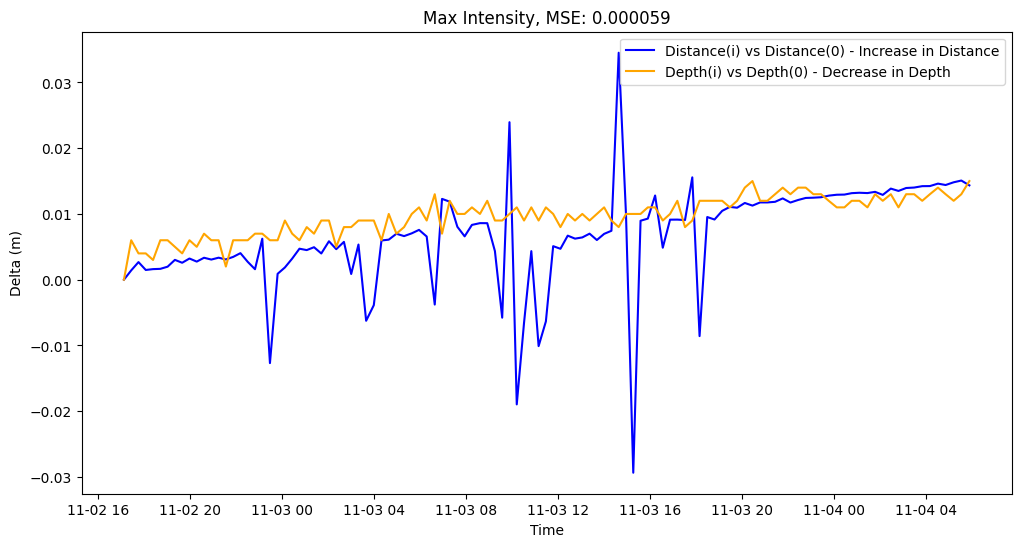

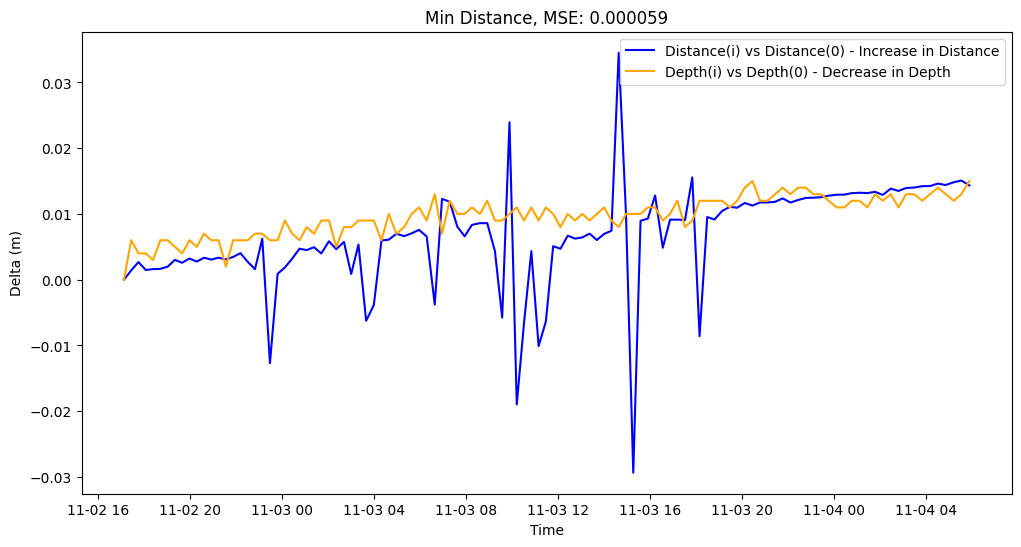

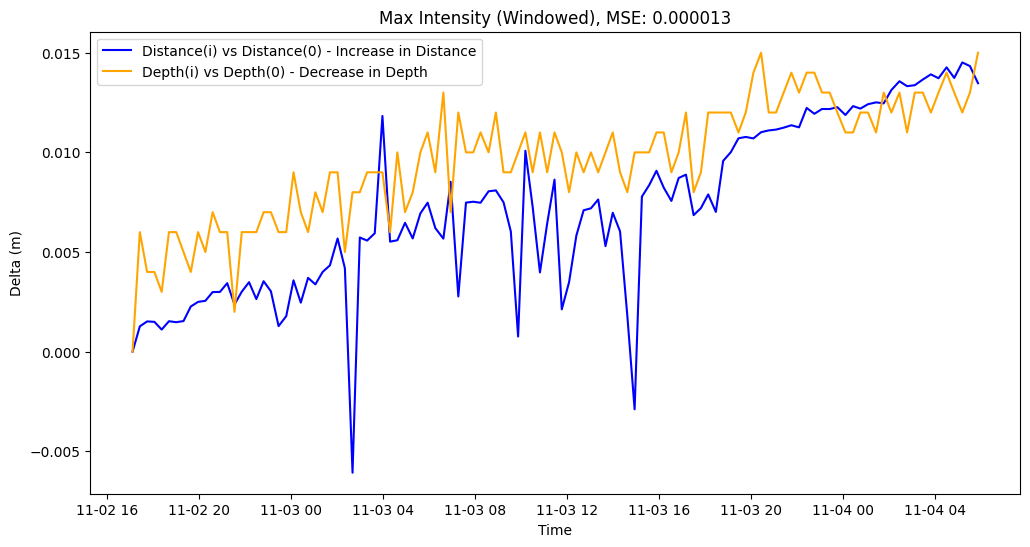

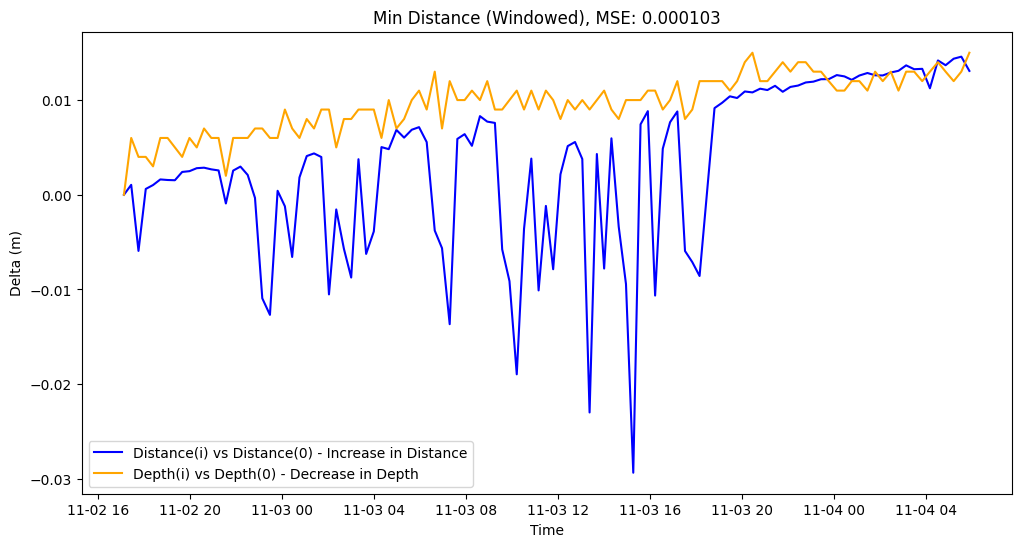

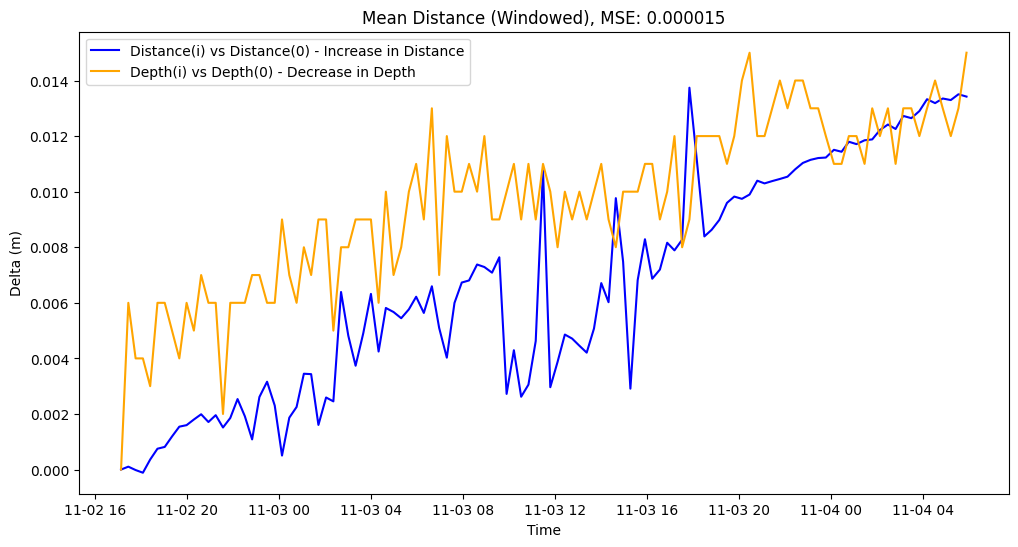

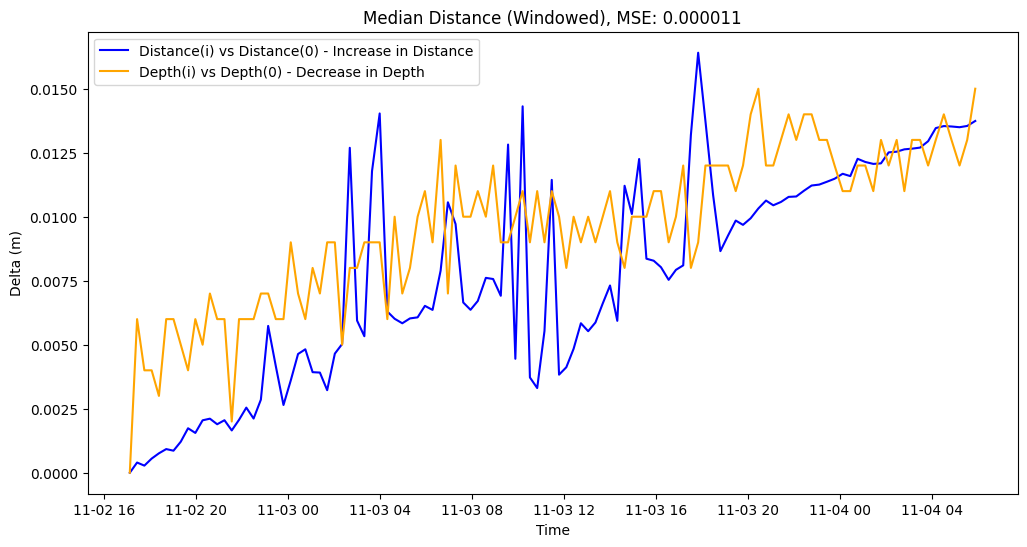

In [17]:
plot.deltas(dates, iwr1443_stats, gt_depths_matched)